# Resultados numericos

## Tarea 1

**Tema:** Ecuación del calor hacia atrás

**Autor:** Felipe Urrutia Vargas

**Profesor:** Axel Osses A.

**Auxiliar:** Jorge Aguayo

Librerias

In [36]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns

Configuración para graficos

In [916]:
plt.style.use(['seaborn', "seaborn-dark"][0])
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})

Plot funcion exponencial

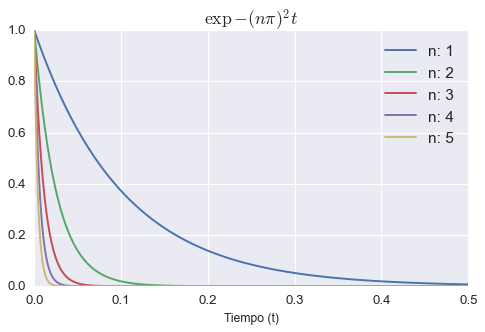

In [917]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
times = np.linspace(0, 0.5, 500)
for n in range(1, 6):
    e1 = np.exp(-((n*np.pi)**2)*times)
    ax.plot(times, e1, label=f"n: {n}")
ax.set_title(u"$\exp{-(n\pi)^2 t}$")
ax.set_xlabel("Tiempo (t)")
plt.legend();
plt.savefig("fig0.pdf", bbox_inches='tight', )

## Problema directo

In [919]:
def solve_heat_equation(N, dt, T, f): # Diferencias finitas
    d1 = np.ones(N-1)
    d0 = np.ones(N)
    d_1 = np.ones(N-1)

    D = np.array([dt*d1, (1-2*dt)*d0, dt*d_1], dtype=object)
    offset = [-1, 0, 1]
    A = diags(D, offset)
    u0 = np.array([f((i+1)/(N+1)) for i in range(N)]) 

    U = np.zeros((N+2, T+1))
    U[1:-1, 0] = u0
    ut_1 = u0
    for t in range(T):
        ut = A @ ut_1
        U[1:-1, t+1] = ut
        ut_1 = ut
    return U

In [478]:
def plot(sol, title, cmap="coolwarm", vmin=-1, vmax=1, dt=1/2):
    plt.imshow(sol, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.grid(False)
    plt.xlabel("Tiempo (t)");
    plt.ylabel("Posición (x)");
    plt.title(title);
    
    locs, labels=plt.yticks()
    y_ticks = []
    new_yticks=[np.round(i/(len(locs)-3), 1) for i in range(-1, len(locs)-1)]
    plt.yticks(locs[1:-1],new_yticks[1:-1], rotation=0, horizontalalignment='right');
    
    locs, labels=plt.xticks()
    x_ticks = []
    new_xticks=[np.round(i*dt, 1) for i in range(-1, len(locs)-1)]
    plt.xticks(locs[1:-1],new_xticks[1:-1], rotation=0, horizontalalignment='right');
    

In [868]:
N = 150*1-2
dt = 1/2 - 0.0001
T = 150*4

Ejemplo 1

Wall time: 271 ms


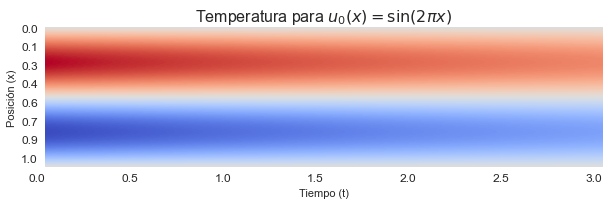

In [869]:
%%time
n=2
f = lambda x: np.sin(n*x*np.pi)
U1 = solve_heat_equation(N, dt, T, f)
plot(
    sol=U1, 
    title=u"Temperatura para $u_0(x) = \sin(2\pi x)$", 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    dt=dt
)
plt.savefig("fig1.pdf", bbox_inches='tight', )

Ejemplo 2

Wall time: 275 ms


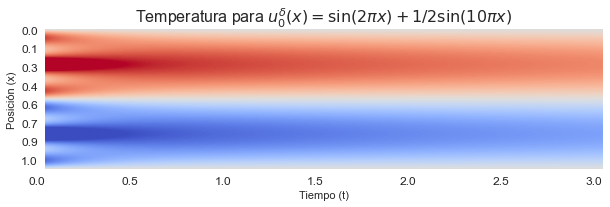

In [870]:
%%time
delta = 0.5
m=n*5
g = lambda x: f(x) + delta * np.sin(m*x*np.pi)
U2 = solve_heat_equation(N, dt, T, g)
plot(
    sol=U2, 
    title=u"Temperatura para $u_0^\delta(x) = \sin(2\pi x) + 1/2 \sin(10\pi x)$", 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    dt=dt
)
plt.savefig("fig2.pdf", bbox_inches='tight', )

Error entre ejemplo 1 y 2

Wall time: 259 ms


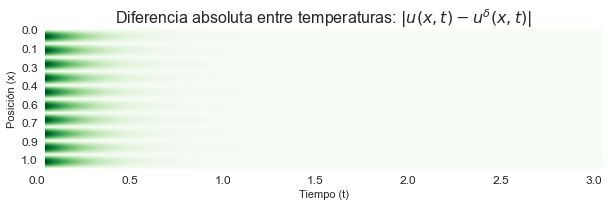

In [871]:
%%time
E = np.abs(U2-U1)
plot(
    sol=E, 
    title=u"Diferencia absoluta entre temperaturas: $|u(x, t)-u^\delta(x, t)|$", 
    cmap="Greens", 
    vmin=0, vmax=None,
    dt=dt
)
plt.savefig("fig3.pdf", bbox_inches='tight', )

## Problema inverso

In [920]:
def solve_backward_heat_equation(N, dt, T, data): # Diferencias finitas
    d1 = np.ones(N-1)
    d0 = np.ones(N)
    d_1 = np.ones(N-1)

    D = np.array([-dt*d1, (1+2*dt)*d0, -dt*d_1], dtype=object)
    offset = [-1, 0, 1]
    A = diags(D, offset)
    uT = np.array([data((i+1)/(N+1)) for i in range(N)]) 

    U = np.zeros((N+2, T+1))
    U[1:-1, T] = uT
    ut = uT
    for t in range(T):
        ut_1 = A @ ut
        ut_1 = np.convolve(ut_1, np.array([1, 2, 1])/4)
        ut_1 = ut_1[1:-1]
#         ut_1 = np.convolve(ut_1, np.array([2, 3, 9, 3, 2])/19)
#         ut_1 = ut_1[2:-2]
        U[1:-1, T-t-1] = ut_1
        ut = ut_1
    return U

Ejemplo 1 (inverso)

In [873]:
%%time
n=2

N = 148
dt0 = 1/2-0.0001
dt = dt0
T0 = T
T = int(dt0 * T0 / dt)

data = lambda x: np.sin(n*x*np.pi)*0.675
B1 = solve_backward_heat_equation(N, dt, T, data)

Wall time: 22 ms


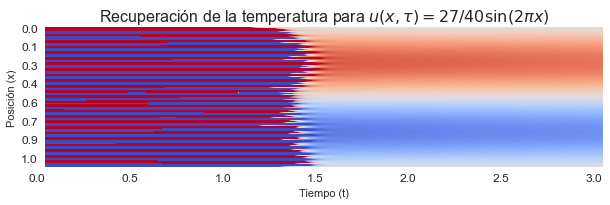

In [875]:
plot(
    sol=B1, 
    title=u"Recuperación de la temperatura para $u(x, \\tau) = 27/40 \sin(2\pi x)$", 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    dt=dt
)
plt.savefig("fig4.pdf", bbox_inches='tight', )

Error entre directo e inverso

Wall time: 269 ms


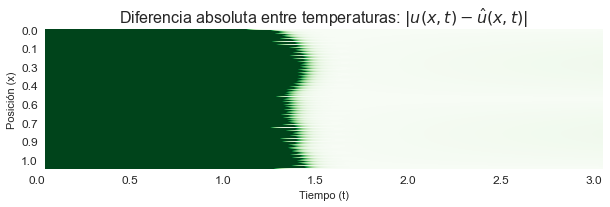

In [877]:
%%time
E1 = np.abs(U1-B1)
plot(
    sol=E1, 
    title=u"Diferencia absoluta entre temperaturas: $|u(x, t)-\hat{u}(x, t)|$", 
    cmap="Greens", 
    vmin=0, vmax=2,
    dt=dt
)
plt.savefig("fig5.pdf", bbox_inches='tight', )